<a href="https://colab.research.google.com/github/Heibattttt/ADM.Homework5/blob/main/Untitled25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import plotly.express as px
import plotly.graph_objects as go

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("flashgordon/usa-airport-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/flashgordon/usa-airport-dataset/versions/2


In [33]:
airports_df = pd.read_csv(f"{path}/Airports2.csv")
print(airports_df.info())
print(airports_df.describe())
print(airports_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB
None
         Passengers         Seats       Flights      Distance  \
count  3.606803e+06  3.606803e+06  3.606803e+06  3.606803e+06   
mean   2.688910e+03  4.048297e+03  3.722890e+01  6.973190e+

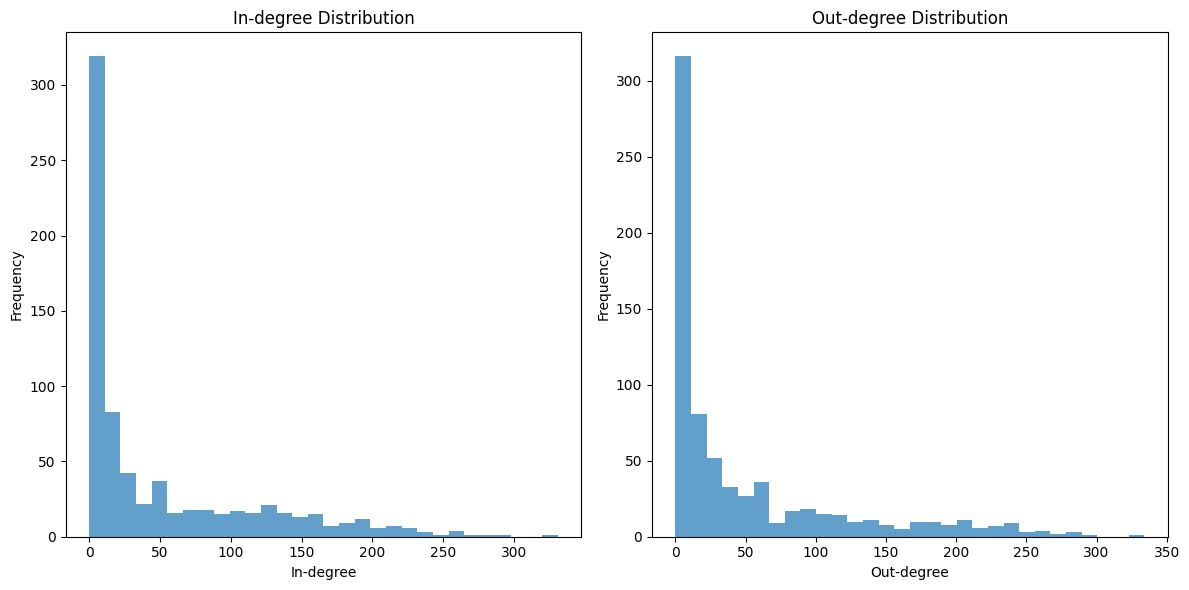

Hubs identified: ['BDL', 'ATL', 'BHM', 'BNA', 'BOS', 'BUF', 'BWI', 'CAE', 'CLE', 'CLT', 'CMH', 'CVG', 'DAY', 'DSM', 'DTW', 'EWR', 'FLL', 'FWA', 'GRR', 'GSO', 'GSP', 'IAD', 'ICT', 'IND', 'JAX', 'JFK', 'LAS', 'LAX', 'LEX', 'LGA', 'LIT', 'MCI', 'MCO', 'MDW', 'MEM', 'MIA', 'MKE', 'MSN', 'MSP', 'MSY', 'OKC', 'OMA', 'ORD', 'PHL', 'PIT', 'RDU', 'RFD', 'SLC', 'STL', 'TOL', 'TPA', 'TYS', 'ABQ', 'AUS', 'DAL', 'DFW', 'ELP', 'HOU', 'IAH', 'LRD', 'PHX', 'RNO', 'SAN', 'SAT', 'SHV', 'TUS', 'COS', 'OAK', 'PDX', 'SEA', 'SFO', 'TUL', 'YIP']


Summary of Graph Features:
{'Number of Nodes': 727, 'Number of Edges': 36719, 'Density': 0.1391392984490396, 'Graph Type': 'dense', 'Hubs': ['BDL', 'ATL', 'BHM', 'BNA', 'BOS', 'BUF', 'BWI', 'CAE', 'CLE', 'CLT', 'CMH', 'CVG', 'DAY', 'DSM', 'DTW', 'EWR', 'FLL', 'FWA', 'GRR', 'GSO', 'GSP', 'IAD', 'ICT', 'IND', 'JAX', 'JFK', 'LAS', 'LAX', 'LEX', 'LGA', 'LIT', 'MCI', 'MCO', 'MDW', 'MEM', 'MIA', 'MKE', 'MSN', 'MSP', 'MSY', 'OKC', 'OMA', 'ORD', 'PHL', 'PIT', 'RDU', 'RFD', 'SLC', 'STL', 'TOL', 'TPA', 'TYS', 'ABQ', 'AUS', 'DAL', 'DFW', 'ELP', 'HOU', 'IAH', 'LRD', 'PHX', 'RNO', 'SAN', 'SAT', 'SHV', 'TUS', 'COS', 'OAK', 'PDX', 'SEA', 'SFO', 'TUL', 'YIP']}

Busiest Routes by Traffic:
           Origin_city Destination_city  Passengers
7122        Dallas, TX      Houston, TX    38295025
12391      Houston, TX       Dallas, TX    37989016
13585      Kahului, HI     Honolulu, HI    32364664
12259     Honolulu, HI      Kahului, HI    29744742
16133  Los Angeles, CA     Honolulu, HI    28964232
12264  

In [34]:
# Function to create a flight network graph from the dataset
def create_flight_network(data):
    G = nx.DiGraph()  # Directed graph because flights have direction (origin to destination)

    # Aggregate passengers by (origin, destination)
    aggregated_data = data.groupby(['Origin_airport', 'Destination_airport'], as_index=False)['Passengers'].sum()

    for _, row in aggregated_data.iterrows():
        origin = row['Origin_airport']
        destination = row['Destination_airport']
        passengers = row['Passengers']

        # Add edge with passengers as weight
        G.add_edge(origin, destination, weight=passengers)

    return G, aggregated_data

# Function to analyze the basic graph features
def analyze_graph_features(flight_network):
    num_nodes = len(flight_network.nodes)
    num_edges = len(flight_network.edges)

    # Graph density
    density = 2 * num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0

    # Efficient In-degree and Out-degree calculation using pandas
    in_degrees = pd.Series([flight_network.in_degree(node) for node in flight_network.nodes], index=flight_network.nodes)
    out_degrees = pd.Series([flight_network.out_degree(node) for node in flight_network.nodes], index=flight_network.nodes)

    # Identify hubs (90th percentile degree)
    all_degrees = in_degrees + out_degrees
    percentile_90 = np.percentile(all_degrees, 90)
    hubs = all_degrees[all_degrees > percentile_90].index.tolist()

    # Sparse or Dense?
    graph_type = "dense" if density >= 0.01 else "sparse"

    # Return analysis data
    return {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'density': density,
        'in_degrees': in_degrees,
        'out_degrees': out_degrees,
        'hubs': hubs,
        'graph_type': graph_type
    }

# Function to generate a summary report
def summarize_graph_features(flight_network):
    analysis_results = analyze_graph_features(flight_network)

    # Create a summary report
    summary_report = {
        "Number of Nodes": analysis_results['num_nodes'],
        "Number of Edges": analysis_results['num_edges'],
        "Density": analysis_results['density'],
        "Graph Type": analysis_results['graph_type'],
        "Hubs": analysis_results['hubs']
    }

    # Plot histograms for in-degree and out-degree (limited number of bins to improve speed)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(analysis_results['in_degrees'], bins=30, alpha=0.7, label='In-degree')
    plt.xlabel('In-degree')
    plt.ylabel('Frequency')
    plt.title('In-degree Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(analysis_results['out_degrees'], bins=30, alpha=0.7, label='Out-degree')
    plt.xlabel('Out-degree')
    plt.ylabel('Frequency')
    plt.title('Out-degree Distribution')

    plt.tight_layout()
    plt.show()

    print("Hubs identified:", analysis_results['hubs'])

    # Return the summary report
    return summary_report

# Efficient computation of passenger flow
def compute_passenger_flow(data):
    passenger_flow = data.groupby(['Origin_city', 'Destination_city'])['Passengers'].sum().reset_index()
    return passenger_flow

# Efficiently identify the busiest routes by passenger traffic
def busiest_routes_by_traffic(data):
    passenger_flow = compute_passenger_flow(data)
    busiest_routes = passenger_flow.sort_values(by='Passengers', ascending=False).head(10)
    return busiest_routes

# Calculate the average passengers per flight for each route
def route_efficiency(data):
    avg_passengers = data.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].mean().reset_index()
    return avg_passengers

# Highlight under-utilized and over-utilized routes
def highlight_utilized_routes(data, avg_passengers):
    total_passengers = data.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
    total_passengers = total_passengers.merge(avg_passengers, on=['Origin_airport', 'Destination_airport'], suffixes=('_total', '_avg'))

    total_passengers['utilization'] = total_passengers['Passengers_total'] / total_passengers['Passengers_avg']
    under_utilized = total_passengers[total_passengers['utilization'] < 1]
    over_utilized = total_passengers[total_passengers['utilization'] > 1]

    return under_utilized, over_utilized

# Optimized interactive map to visualize flight routes (limit routes to top 50)
def plot_interactive_map(data, flight_network):
    locations = data[['Origin_airport', 'Origin_city', 'Org_airport_lat', 'Org_airport_long']].drop_duplicates()
    locations = locations.rename(columns={'Org_airport_lat': 'Latitude', 'Org_airport_long': 'Longitude'})

    fig = px.scatter_geo(locations, lat='Latitude', lon='Longitude', hover_name='Origin_city', title='Airports in the Flight Network')

    # Add a limited number of flight routes (top 50)
    count = 0
    for u, v in flight_network.edges:
        if count >= 50:  # Limit to top 50 routes
            break
        origin = data[data['Origin_airport'] == u].iloc[0]
        destination = data[data['Destination_airport'] == v].iloc[0]
        fig.add_trace(go.Scattergeo(
            lon=[origin['Org_airport_long'], destination['Dest_airport_long']],
            lat=[origin['Org_airport_lat'], destination['Dest_airport_lat']],
            mode='lines',
            line=dict(width=1, color='blue'),
            opacity=0.5
        ))
        count += 1

    fig.update_geos(projection_type="mercator")
    fig.update_layout(showlegend=False)
    fig.show()

# Load your dataset (Airports2)
airports2 = pd.read_csv(f"{path}/Airports2.csv")

# Create flight network
flight_network, aggregated_data = create_flight_network(airports2)

# Analyze graph features
summary = summarize_graph_features(flight_network)

# Analyze busiest routes
busiest_routes = busiest_routes_by_traffic(airports2)

# Calculate route efficiency
avg_passengers = route_efficiency(airports2)

# Highlight under/over-utilized routes
under_utilized, over_utilized = highlight_utilized_routes(airports2, avg_passengers)

# Visualize the interactive map of flight network
plot_interactive_map(airports2, flight_network)

# Print results
print("Summary of Graph Features:")
print(summary)
print("\nBusiest Routes by Traffic:")
print(busiest_routes)
print("\nUnder-utilized Routes:")
print(under_utilized)
print("\nOver-utilized Routes:")
print(over_utilized)


# Q 2.1

In [35]:
#function that computes the following centrality measures for a given airport:
def analyze_centrality(flight_network, airport):

    betweenness = nx.betweenness_centrality(flight_network, normalized=True, weight='weight')

    closeness = nx.closeness_centrality(flight_network, distance='weight')

    degree = flight_network.degree(airport, weight='weight')

    pagerank = nx.pagerank(flight_network, weight='weight')

    #results for the given airport
    centrality_results = {
        'Airport': airport,
        'Betweenness Centrality': betweenness.get(airport, 0),
        'Closeness Centrality': closeness.get(airport, 0),
        'Degree Centrality': degree,
        'PageRank': pagerank.get(airport, 0)
    }

    return centrality_results

results = analyze_centrality(flight_network, 'JFK')
print(results)


{'Airport': 'JFK', 'Betweenness Centrality': 3.8217158502439397e+65, 'Closeness Centrality': 0.018087814480641836, 'Degree Centrality': 280781960, 'PageRank': 0.010402095296131958}


# Q 2.2

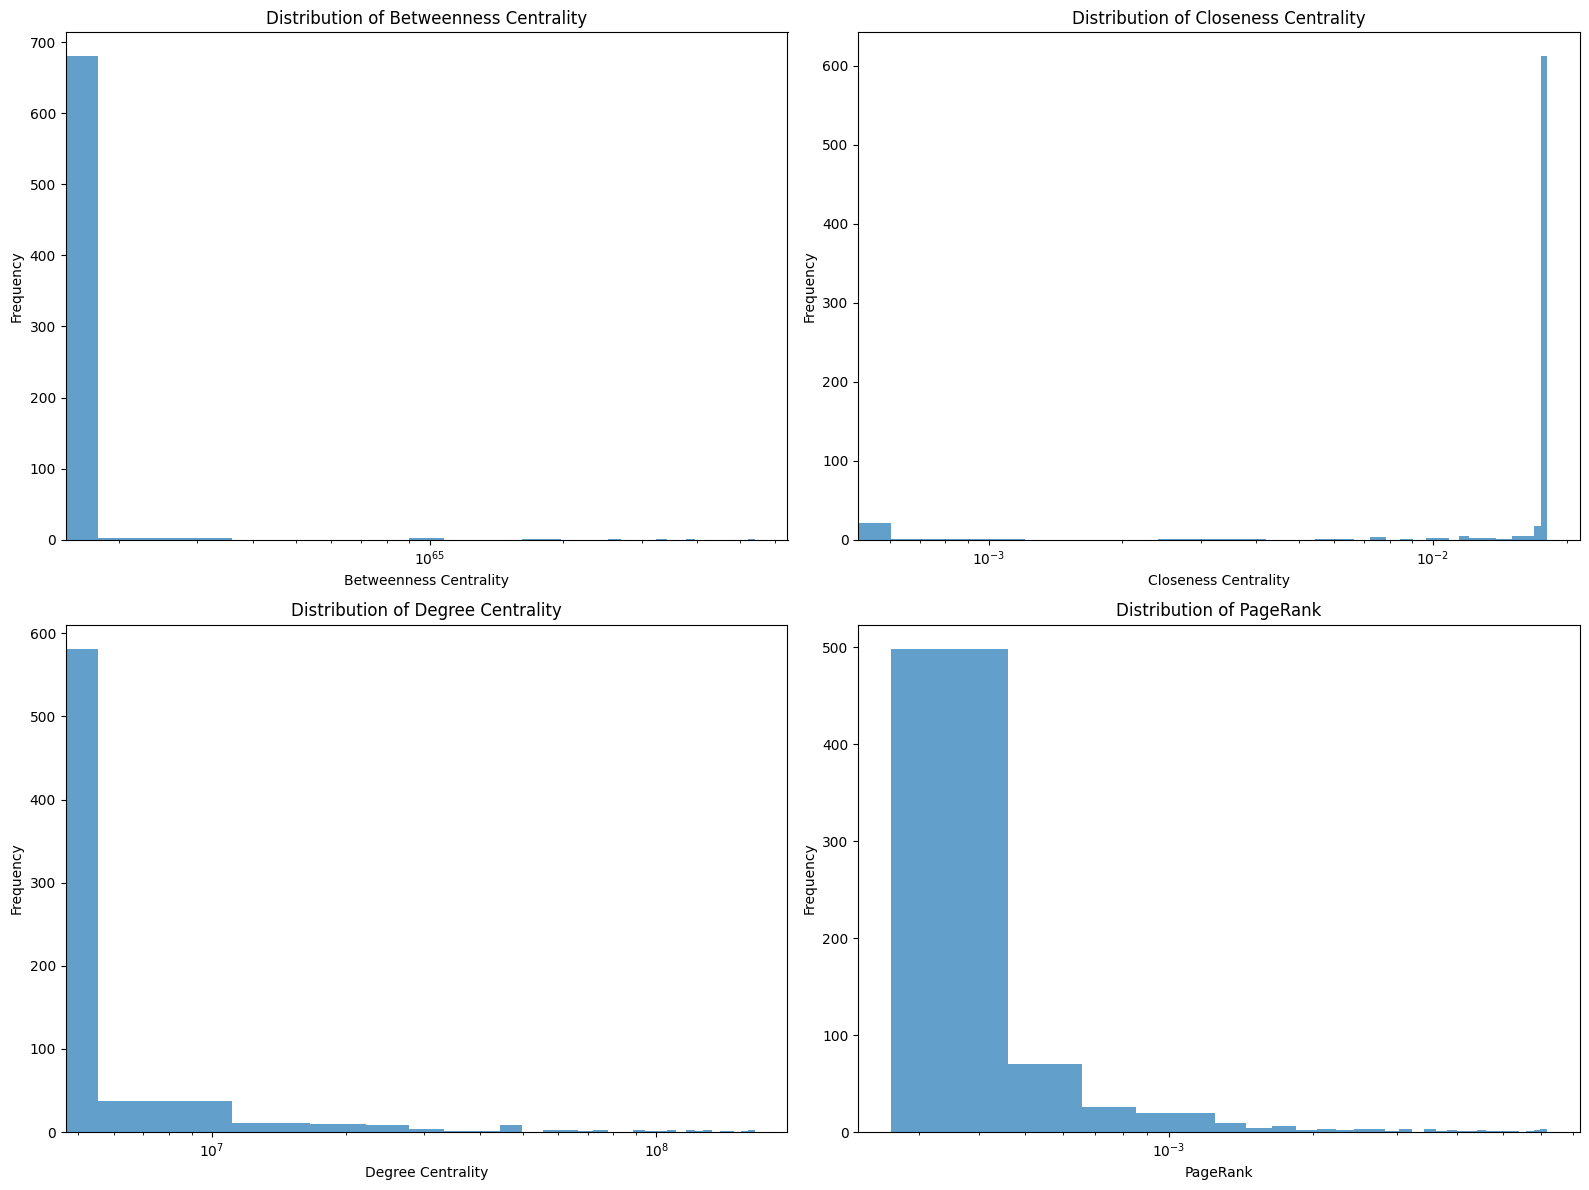

Top 5 airports by Betweenness Centrality:
['OMA', 'ATL', 'MKE', 'STL', 'YIP']

Top 5 airports by Closeness Centrality:
['BYI', 'TDW', 'STE', 'HUA', 'SME']

Top 5 airports by Degree Centrality:
['ATL', 'ORD', 'DFW', 'LAX', 'PHX']

Top 5 airports by PageRank:
['ATL', 'ORD', 'DFW', 'LAX', 'MSP']



In [36]:
'''
function to
* Compute and compare centrality values for all nodes in the graph.
* Plot centrality distributions (histograms for each centrality measure).
* Return the top 5 airports for each centrality measure.
'''
def compare_centralities(flight_network):

    #centralities for all nodes
    betweenness = nx.betweenness_centrality(flight_network, normalized=True, weight='weight')
    closeness = nx.closeness_centrality(flight_network, distance='weight')
    degree = dict(flight_network.degree(weight='weight'))
    pagerank = nx.pagerank(flight_network, weight='weight')

    #combine centralities into DataFrame
    centralities_df = pd.DataFrame({
        'Betweenness Centrality': betweenness,
        'Closeness Centrality': closeness,
        'Degree Centrality': degree,
        'PageRank': pagerank
    })

    plt.figure(figsize=(16, 12))
    for i, metric in enumerate(centralities_df.columns):
        plt.subplot(2, 2, i + 1)
        data = centralities_df[metric]

        data_without_outliers = data[data < np.percentile(data, 95)]

        plt.hist(data_without_outliers, bins=30, alpha=0.7)
        plt.title(f'Distribution of {metric}')
        plt.xlabel(f'{metric}')
        plt.ylabel('Frequency')
        plt.xscale('log')  #log scale for better visualization
    plt.tight_layout()
    plt.show()

    #top 5 nodes
    top_5_airports = {
        metric: centralities_df[metric].nlargest(5).index.tolist()
        for metric in centralities_df.columns
    }

    return top_5_airports

top_5 = compare_centralities(flight_network)

for centrality, airports in top_5.items():
    print(f"Top 5 airports by {centrality}:")
    print(airports)
    print()


### **Summary of Results**

- **Betweenness Centrality**:
  - High values for OMA, MKE, and STL indicate their importance in connecting regions.
  - ATL is a major global hub, consistently appearing in top rankings.

- **Closeness Centrality**:
  - Airports like BYI and TDW rank high due to their proximity to other nodes in the network, emphasizing their local importance.

- **Degree Centrality**:
  - Top hubs (ATL, ORD, DFW) dominate due to their high number of connections, reflecting their global role in the flight network.

- **PageRank**:
  - Similar to Degree Centrality, highlighting key hubs like ATL, ORD, and LAX with additional weight on their importance.


- The network is highly centralized with a few key nodes (ATL, ORD, DFW) controlling most connectivity.
- Local hubs (OMA, BYI) play critical roles in regional connectivity.
- High Betweenness airports are crucial for maintaining overall network flow.


# Q 2.3

### Alternative Centrality Measures for Analysis

1. **Harmonic Centrality**  
   - Accounts for inverse distances and works well in weakly connected graphs.  
   - Provides non-zero values for nodes in disconnected components.

2. **Eigenvector Centrality**  
   - Measures the influence of a node based on the importance of its neighbors.  
   - Suitable for detecting globally important hubs.  

3. **Katz Centrality**  
   - Extends eigenvector centrality by giving all nodes a base-level importance.  
   - Useful for weakly connected or directed graphs.

4. **Percolation Centrality**  
   - Tracks the impact of a node in spreading information through a network.  
   - Relevant for dynamic or communication-based networks.

5. **Load Centrality**  
   - Similar to betweenness centrality but considers flow-based measures.  
   - Useful for analyzing congestion or capacity in networks.

6. **Clustering Coefficient**  
   - Measures the tendency of nodes to form tightly-knit groups.  
   - Indicates local connectivity patterns around nodes.

### Verifying the Results
To ensure the trustability of the results:
- Compare new metrics with existing ones like Degree Centrality or Betweenness Centrality.
- Check the consistency of top-ranked nodes across different centrality measures.
- Visualize and analyze the distributions of the new metrics to identify outliers or anomalies.


# Q 2.4

In [37]:
#сheck strong and weak connectivity
if nx.is_strongly_connected(flight_network):
    print("The graph is strongly connected.")
elif nx.is_weakly_connected(flight_network):
    print("The graph is weakly connected.")
else:
    print("The graph is disconnected.")


The graph is weakly connected.


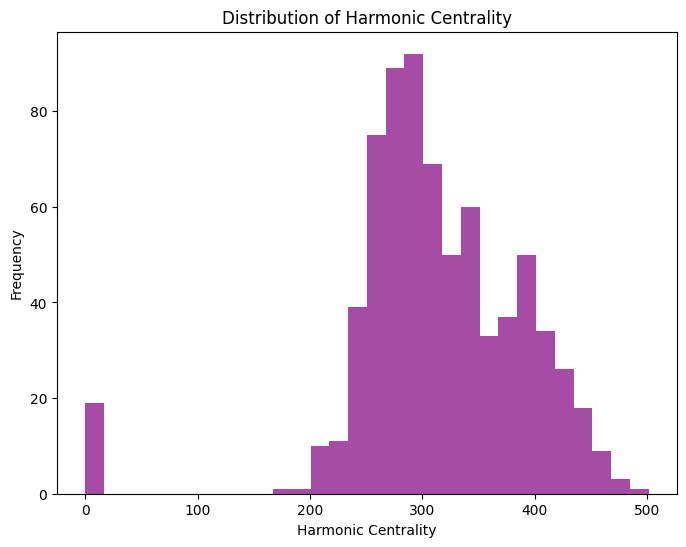

Top 5 airports by Harmonic Centrality: ['YIP', 'MSP', 'MEM', 'MCI', 'STL']


In [38]:
#сalculate Harmonic Centrality
harmonic_centrality = nx.harmonic_centrality(flight_network)

harmonic_df = pd.DataFrame.from_dict(harmonic_centrality, orient='index', columns=['Harmonic Centrality'])

#distribution of Harmonic Centrality
plt.figure(figsize=(8, 6))
plt.hist(harmonic_df['Harmonic Centrality'], bins=30, alpha=0.7, color='purple')
plt.title('Distribution of Harmonic Centrality')
plt.xlabel('Harmonic Centrality')
plt.ylabel('Frequency')
plt.show()

#top 5 nodes by Harmonic Centrality
top_5_harmonic = harmonic_df['Harmonic Centrality'].nlargest(5).index.tolist()
print("Top 5 airports by Harmonic Centrality:", top_5_harmonic)


### Comparison of Closeness Centrality and Harmonic Centrality

**Closeness Centrality**
- Most values are concentrated around 10^(-2), with many nodes having near-zero centrality <10^(-3).
- Nodes in disconnected components are assigned a centrality of 0.
- Not suitable for weakly connected graphs.

**Harmonic Centrality**
- Values are distributed over a wider range (200–400), providing meaningful results even for isolated nodes.
- Compensates for the lack of direct paths by considering inverse distances.

**Conclusion**
- **Harmonic Centrality** is more reliable for weakly connected graphs, capturing both local and global accessibility.
- **Closeness Centrality** should only be used for strongly connected components.


# Q3

We check that there are no empty values in the Distance column for correct graph construction.

In [39]:
missing_values = airports2.isnull().sum()
print(missing_values)

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64


In [40]:
from IPython.display import display

def create_graph_from_dataframe(df):
    """
    Create a directed graph from a DataFrame with edges weighted by distance.
    """
    G = nx.DiGraph()
    for _, row in df.iterrows():
        if not pd.isnull(row['Distance']):
            G.add_edge(
                row['Origin_airport'],
                row['Destination_airport'],
                weight=row['Distance']
            )
    return G


def find_best_routes(flight_network_df, origin_city, destination_city, fly_date):
    """
    Find the best routes (shortest by distance) between airports in two cities for a given date.
    """
    filtered_data = flight_network_df[flight_network_df['Fly_date'] == fly_date]

    G = create_graph_from_dataframe(filtered_data)

    origin_airports = filtered_data[filtered_data['Origin_city'] == origin_city]['Origin_airport'].unique()
    destination_airports = filtered_data[filtered_data['Destination_city'] == destination_city]['Destination_airport'].unique()

    best_routes = []

    for origin in origin_airports:
        for destination in destination_airports:
            try:
                path = nx.shortest_path(G, source=origin, target=destination, weight='weight')
                best_routes.append({
                    'Origin_city_airport': origin,
                    'Destination_city_airport': destination,
                    'Best_route': ' → '.join(path)
                })
            except nx.NetworkXNoPath:
                best_routes.append({
                    'Origin_city_airport': origin,
                    'Destination_city_airport': destination,
                    'Best_route': 'No route found'
                })

    return pd.DataFrame(best_routes)

best_route_df = find_best_routes(airports2, 'Seattle, WA', 'Bend, OR', '1990-02-01')

from IPython.display import display
display(best_route_df)


,Origin_city_airport,Destination_city_airport,Best_route
0,SEA,RDM,SEA → RDM
1,BFI,RDM,BFI → SEA → RDM


In [41]:
#trying more examples

examples = [
    {'origin_city': 'Eugene, OR', 'destination_city': 'Bend, OR', 'fly_date': '1990-11-01'},
    {'origin_city': 'Medford, OR', 'destination_city': 'Bend, OR', 'fly_date': '1990-02-01'},
    {'origin_city': 'Seattle, WA', 'destination_city': 'Bend, OR', 'fly_date': '1990-02-01'},
    {'origin_city': 'Manhattan, KS', 'destination_city': 'Ames, IA', 'fly_date': '2008-10-01'},
]


all_results = pd.DataFrame()

for example in examples:
    result = find_best_routes(
        flight_network_df=airports2,
        origin_city=example['origin_city'],
        destination_city=example['destination_city'],
        fly_date=example['fly_date']
    )
    all_results = pd.concat([all_results, result], ignore_index=True)



display(all_results)


,Origin_city_airport,Destination_city_airport,Best_route
0,EUG,RDM,EUG → RDM
1,MFR,RDM,MFR → RDM
2,SEA,RDM,SEA → RDM
3,BFI,RDM,BFI → SEA → RDM
4,MHK,AMW,MHK → AMW
